### Analisis Finanzas 
#### Segundo desafio
¿Los clientes con préstamos e hipotecas tienden a tener un saldo medio más bajo o más riesgo de incumplimiento? ¿Cómo deberíamos ajustar nuestras ofertas y estrategias de gestión de riesgos en función de estos hallazgos?

#### Librerias y más

In [35]:
"""Librerías que pueden ser necesarias"""

# Manejo de datos
import pandas as pd                 # Análisis y manipulación de datos en tablas
import numpy as np                  # Cálculos numéricos y matrices
import os                           # Gestión de rutas de archivos
import re                           # Expresiones regulares para búsqueda y manipulación de texto

# Visualización de datos
import matplotlib.pyplot as plt     # Gráficos básicos en 2D
import seaborn as sns               # Gráficos estadísticos mejorados
import plotly.express as px         # Gráficos interactivos simplificados
import plotly.graph_objects as go   # Control avanzado de gráficos en Plotly
import plotly.io as pio             # Interfaz de entrada/salida de Plotly
import squarify                     # Visualización de diagramas de "treemap"

# Procesado y análisis
from scipy import stats
from scipy.stats import chi2_contingency # Pruebas de hipótesis y análisis estadístico
from scipy.stats import norm
from matplotlib.patches import Patch

import warnings
warnings.filterwarnings("ignore")#ignorar advertencias

#Paleta de colores oficial
custom_palette = [ "#2CCED1", "#5F6F81", "#AABBC8", "#DCE3EA", "#2E2F36"]

#### Carga de datos

In [2]:
df = pd.read_csv('../Data/df_250519.csv')

#### Tabla relacion Prestamos e hipotecas
Se analiza si tiene prestamo, si tiene hipoteca, Saldo medio y tasa de incumplimiento

   Tiene préstamo  Tiene hipoteca  Saldo medio  Tasa incumplimiento  \
0           False           False  1844.047228             0.008864   
1           False            True  1365.205982             0.013876   
2            True           False   801.467991             0.057395   
3            True            True   773.169967             0.026403   

   Número de clientes  
0                7559  
1                6486  
2                 906  
3                1212  


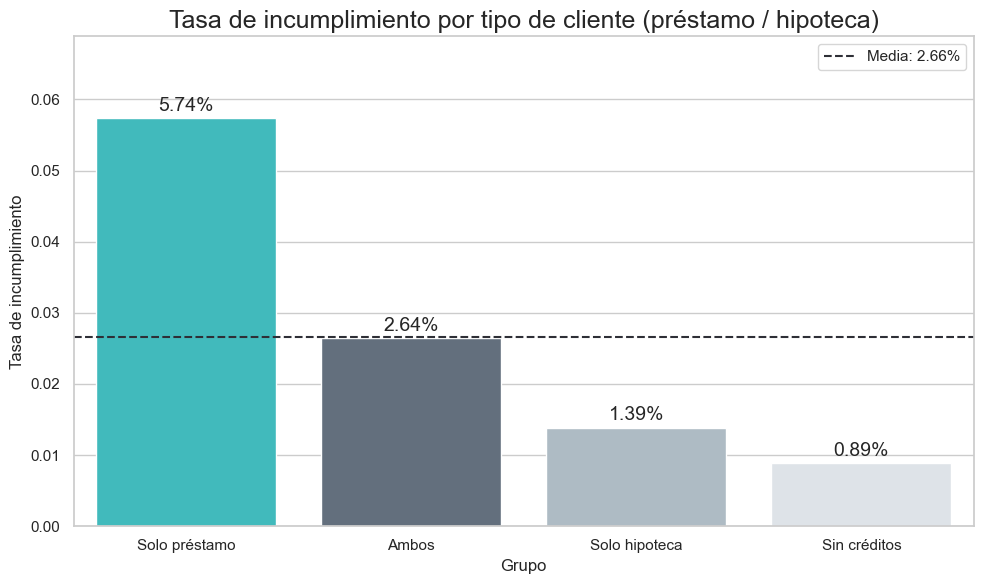

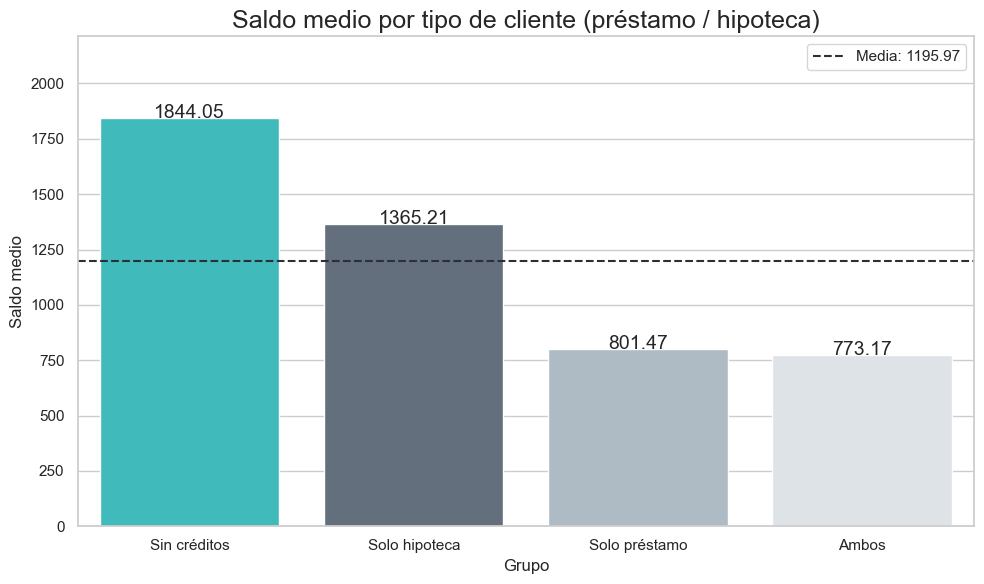

In [19]:
Tabla_agrupada = df.groupby(['loan', 'housing']).agg({'balance': 'mean','default': 'mean','id': 'count'}).reset_index()
Tabla_agrupada.columns = ['Tiene préstamo', 'Tiene hipoteca', 'Saldo medio', 'Tasa incumplimiento', 'Número de clientes'] 
print(Tabla_agrupada)

'''Esteos graficos se puede cambiar de orden para mostrarlos de manera inversa 
prestamo como Hue y hipoteca como x

sns.barplot(data=Tabla_agrupada, x='Tiene préstamo', y='Tasa incumplimiento', hue='Tiene hipoteca', palette=custom_palette)
plt.title("Tasa de incumplimiento por tipo de préstamo e hipoteca")
plt.ylabel("Tasa de incumplimiento")
plt.show()

sns.barplot(data=Tabla_agrupada, x='Tiene préstamo', y='Saldo medio', hue='Tiene hipoteca', palette=custom_palette)
plt.title("Saldo por tipo de préstamo e hipoteca")
plt.ylabel("Saldo")
plt.show()'''

# Barras combinadas tasa de incumplimiento
df_viz = Tabla_agrupada.copy()
def clasificar_cliente(row):
    if row['Tiene préstamo'] and row['Tiene hipoteca']:
        return "Ambos"
    elif row['Tiene préstamo'] and not row['Tiene hipoteca']:
        return "Solo préstamo"
    elif not row['Tiene préstamo'] and row['Tiene hipoteca']:
        return "Solo hipoteca"
    else:
        return "Sin créditos"
    
media_tasa = df_viz['Tasa incumplimiento'].mean()
media_saldo = df_viz['Saldo medio'].mean()
df_viz['Grupo'] = df_viz.apply(clasificar_cliente, axis=1)
# Ordenar los grupos
orden = ["Solo préstamo", "Ambos", "Solo hipoteca", "Sin créditos"]
df_viz['Grupo'] = pd.Categorical(df_viz['Grupo'], categories=orden, ordered=True)
df_viz = df_viz.sort_values('Grupo')

plt.figure(figsize=(10,6))
sns.barplot(x='Grupo', y='Tasa incumplimiento', data=df_viz, palette= custom_palette)

plt.title('Tasa de incumplimiento por tipo de cliente (préstamo / hipoteca)', fontsize=18)
plt.ylabel('Tasa de incumplimiento')
plt.ylim(0, df_viz['Tasa incumplimiento'].max()*1.2)

for idx, (_, row) in enumerate(df_viz.iterrows()):
    plt.text(idx, row['Tasa incumplimiento'] + 0.001, f"{row['Tasa incumplimiento']:.2%}", ha='center', fontsize=14)
plt.axhline(media_tasa, color="#2E2F36", linestyle='--', linewidth=1.5, label=f'Media: {media_tasa:.2%}')
plt.legend()
plt.tight_layout()
plt.show()

#barras combinadas saldo medio
orden2 = [ "Sin créditos", "Solo hipoteca","Solo préstamo", "Ambos"]
df_viz['Grupo'] = pd.Categorical(df_viz['Grupo'], categories=orden2, ordered=True)
df_viz = df_viz.sort_values('Grupo')
plt.figure(figsize=(10,6))  
sns.barplot(x='Grupo', y='Saldo medio', data=df_viz, palette= custom_palette)
plt.title('Saldo medio por tipo de cliente (préstamo / hipoteca)', fontsize=18)
plt.ylabel('Saldo medio')
plt.ylim(0, df_viz['Saldo medio'].max()*1.2)
for idx, (_, row) in enumerate(df_viz.iterrows()):
    plt.text(idx, row['Saldo medio'] + 0.001, f"{row['Saldo medio']:.2f}", ha='center', fontsize=14)
plt.axhline(media_saldo, color="#2E2F36", linestyle='--', linewidth=1.5, label=f'Media: {media_saldo:.2f}')
plt.legend()
plt.tight_layout()
plt.show()    

### Prueba con otros tipos de grafico
##### Burbujas
##### Heatmap

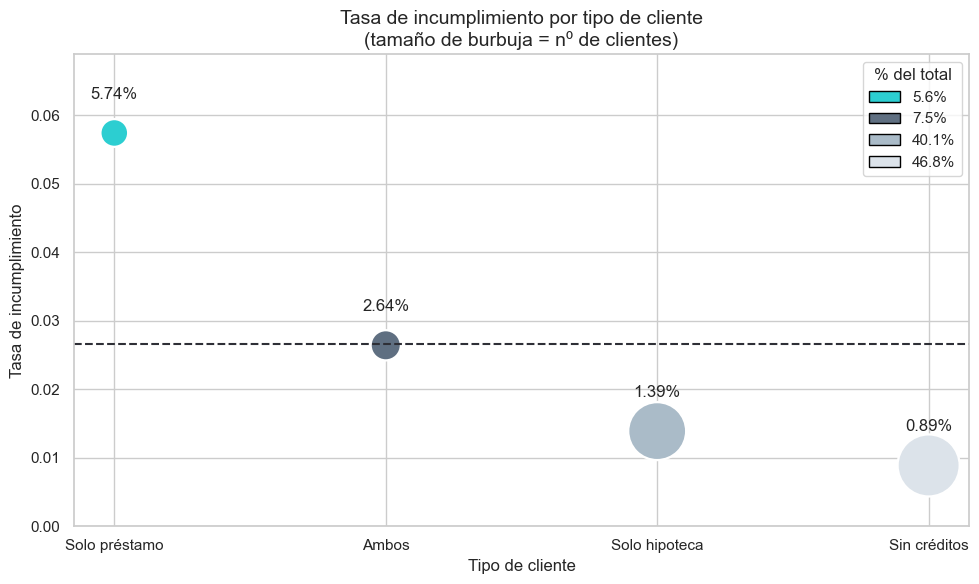

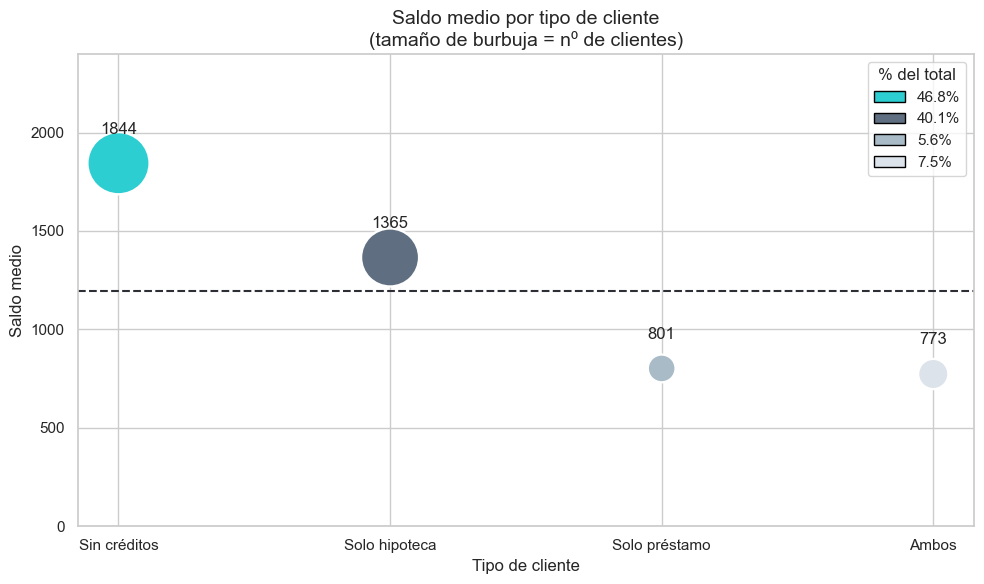

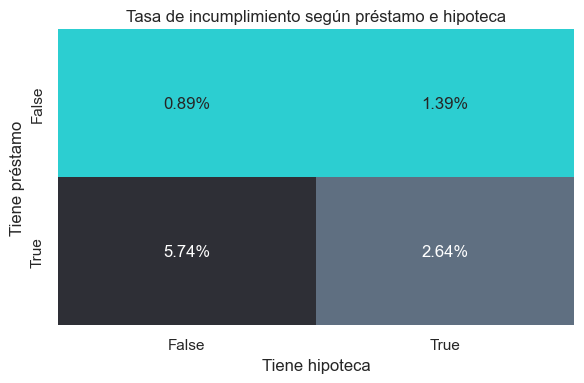

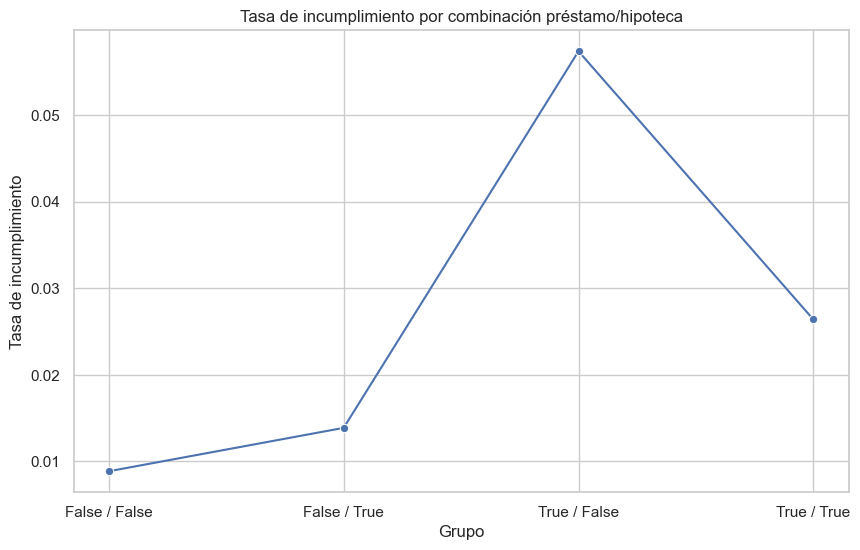

In [61]:
df_viz['Grupo'] = pd.Categorical(df_viz['Grupo'], categories=orden, ordered=True)
df_viz = df_viz.sort_values('Grupo')
media_tasa = df_viz['Tasa incumplimiento'].mean()
total_clientes = df_viz['Número de clientes'].sum()
df_viz['Porcentaje clientes'] = df_viz['Número de clientes'] / total_clientes

# Crear gráfico de burbujas para tasa de incumplimiento
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=df_viz,
    x='Grupo',
    y='Tasa incumplimiento',
    size='Número de clientes',
    hue='Grupo',
    sizes=(400, 2000),
    palette=custom_palette,
    legend=False,
)

# Agregar línea de media
plt.axhline(media_tasa, color="#2E2F36", linestyle='--', linewidth=1.5, label=f'Media: {media_tasa:.2%}')
# etiqueta sobre burbujas
for i, row in enumerate(df_viz.itertuples()):
    plt.text(i, row._4 + 0.005, f"{row._4:.2%}", ha='center', fontsize=12)

# Crear leyenda personalizada con colores y porcentajes
color_dict = dict(zip(df_viz['Grupo'], sns.color_palette(custom_palette)))
legend_elements = [
    Patch(
        facecolor=color_dict[row['Grupo']],
        edgecolor='black',
        label=f"{row['Porcentaje clientes']:.1%}"
    )
    for _, row in df_viz.iterrows()
]

# Mostrar leyenda personalizada
plt.legend(
    handles=legend_elements,
    title="% del total",
    loc='upper right'
)
plt.title("Tasa de incumplimiento por tipo de cliente\n(tamaño de burbuja = nº de clientes)", fontsize=14)
plt.xlabel("Tipo de cliente")
plt.ylabel("Tasa de incumplimiento")
plt.ylim(0, df_viz['Tasa incumplimiento'].max() * 1.2)
plt.tight_layout()
plt.show()

# crear grafico de burbuja para saldo medio
df_viz['Grupo'] = pd.Categorical(df_viz['Grupo'], categories=orden2, ordered=True)
df_viz = df_viz.sort_values('Grupo')
plt.figure(figsize=(10,6))      
sns.scatterplot(
    data=df_viz,
    x='Grupo',
    y='Saldo medio',
    size='Número de clientes',
    hue='Grupo',
    sizes=(400, 2000),
    palette=custom_palette,
    legend=False,
)
# Agregar línea de media
plt.axhline(media_saldo, color="#2E2F36", linestyle='--', linewidth=1.5, label=f'Media: {media_saldo:.2f}')
# etiqueta sobre burbujas       
for i, row in enumerate(df_viz.itertuples()):
    plt.text(i, row._3 + 150, f"{row._3:.0f}", ha='center', fontsize=12)
# Crear leyenda personalizada con colores y porcentajes
color_dict = dict(zip(df_viz['Grupo'], sns.color_palette(custom_palette)))
legend_elements = [
    Patch(
        facecolor=color_dict[row['Grupo']],
        edgecolor='black',
        label=f"{row['Porcentaje clientes']:.1%}"
    )
    for _, row in df_viz.iterrows()
]
# Mostrar leyenda personalizada
plt.legend(
    handles=legend_elements,
    title="% del total",
    loc='upper right'
)
plt.title("Saldo medio por tipo de cliente\n(tamaño de burbuja = nº de clientes)", fontsize=14)
plt.xlabel("Tipo de cliente")
plt.ylabel("Saldo medio")
plt.ylim(0, df_viz['Saldo medio'].max()*1.3)
plt.tight_layout()
plt.show()

# heatmap
heatmap_data = df_viz.pivot(index='Tiene préstamo', columns='Tiene hipoteca', values='Tasa incumplimiento')
plt.figure(figsize=(6, 4))
sns.heatmap(heatmap_data, annot=True, fmt=".2%", cmap=custom_palette, cbar=False)

plt.title('Tasa de incumplimiento según préstamo e hipoteca')
plt.xlabel('Tiene hipoteca')
plt.ylabel('Tiene préstamo')
plt.tight_layout()
plt.show()

#Grafico de lineas
Tabla_agrupada['Grupo'] = Tabla_agrupada['Tiene préstamo'].astype(str) + ' / ' + Tabla_agrupada['Tiene hipoteca'].astype(str)

plt.figure(figsize=(10,6))
sns.lineplot(data=Tabla_agrupada, x='Grupo', y='Tasa incumplimiento', marker='o')
plt.title("Tasa de incumplimiento por combinación préstamo/hipoteca")
plt.ylabel("Tasa de incumplimiento")
plt.xlabel("Grupo")
plt.grid(True)
plt.show()

### Representación gráfica del saldo promedio por tipo de cliente en función de préstamos

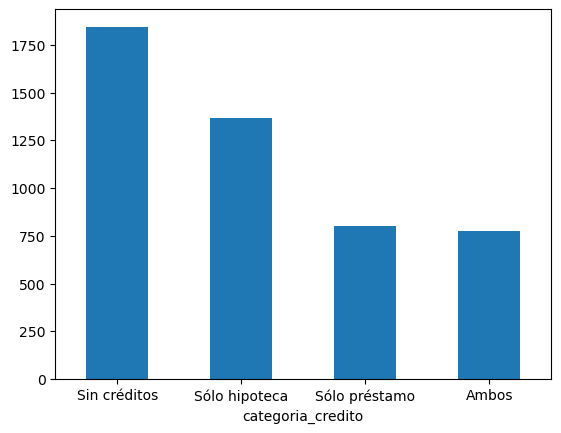

In [ ]:
def categorize_credit(row):
    if not row['loan'] and not row['housing']:
        return 'Sin créditos'
    elif not row['loan'] and row['housing']:
        return 'Sólo hipoteca'
    elif row['loan'] and not row['housing']:
        return 'Sólo préstamo'
    else:
        return 'Ambos'

df['categoria_credito'] = df.apply(categorize_credit, axis=1)

# Agrupar y calcular promedio de balance
balance_promedio = df.groupby('categoria_credito')['balance'].mean().reindex([
    'Sin créditos', 'Sólo hipoteca', 'Sólo préstamo', 'Ambos'])

# Gráfica
balance_promedio.plot(kind='bar')
plt.xticks(rotation=0)
plt.show()

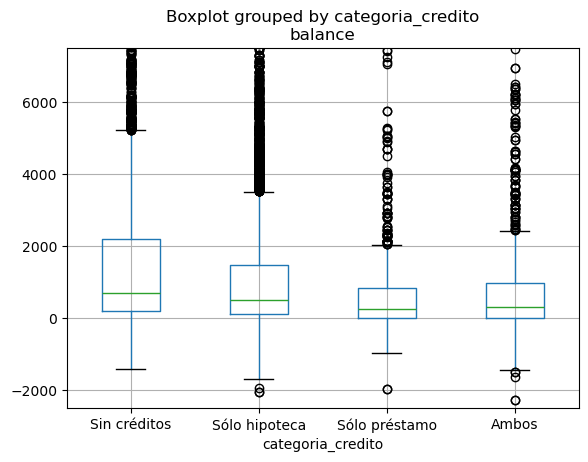

In [ ]:
orden_categorias = ['Sin créditos', 'Sólo hipoteca', 'Sólo préstamo', 'Ambos']
df['categoria_credito'] = pd.Categorical(df['categoria_credito'], categories=orden_categorias, ordered=True)

df.boxplot(column='balance', by='categoria_credito')
plt.ylim(-2500, 7500)
plt.show()

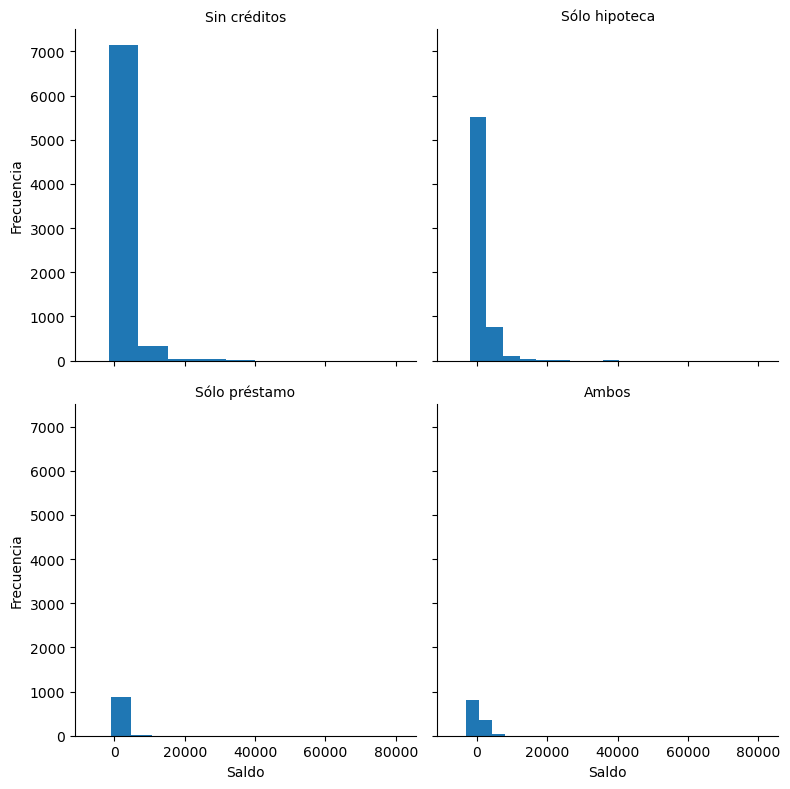

In [ ]:
# Facetgrid con histogramas
g = sns.FacetGrid(df, col='categoria_credito', col_wrap=2, height=4, sharex=True, sharey=True)
g.map(plt.hist, 'balance', bins=10)

g.set_titles(col_template='{col_name}')
g.set_axis_labels('Saldo', 'Frecuencia')
plt.tight_layout()
plt.show()

### Odds Ratio
chances de incumplimiento al tener un prestamo o hipoteca
(odds ratio) se calcula así:
odds ratio = odds de default en expuesto / odds de default en no expuestos.

donde :

odds de default en expuesto  = personas con inpago y con (prestamo, hipoteca) / personas sin inpago y con (prestamo, hipoteca)

odds de default en no expuestos = personas con inpago y sin (prestamo, hipoteca) / personas sin inpago y sin (prestamo, hipoteca)



#### Nota
use odds ratio en lugar de riesgo relativo pues tengo la intencion de hacer una regresion logistica si da tiempo

In [ ]:
def odds_ratio(df, column_a, column_b):
    """Calcula la razón de probabilidades (odds ratio) entre dos grupos."""
    tabla_contingencia = pd.crosstab(df[column_a],df[column_b] )
    A= tabla_contingencia.iloc[1, 1] 
    B= tabla_contingencia.iloc[1, 0] 
    C= tabla_contingencia.iloc[0, 1]
    D= tabla_contingencia.iloc[0, 0]
    # Evitar divisiones por cero
    if B == 0 or D == 0:
        print("⚠️ Uno de los valores es cero, no se puede calcular la razón de momios.")
        return None
    odds_expuesto = A / B
    odds_no_expuesto = C / D
    odds_ratio = odds_expuesto /odds_no_expuesto
    print(f"📊 Tabla de contingencia entre '{column_a}' y '{column_b}':\n{tabla_contingencia}\n")
    print(f"odds_sin_{column_a}: {odds_expuesto}")
    print(f"odds_con_{column_a} : {odds_no_expuesto}")
    print(f"odds_ratio: {odds_ratio}")
    
# aplicar la función a los datos
odds_ratio(df, 'loan', 'default')
odds_ratio(df, 'housing', 'default')


📊 Tabla de contingencia entre 'loan' y 'default':
default  False  True 
loan                 
False    13888    157
True      2034     84

odds_sin_loan: 0.04129793510324484
odds_con_loan : 0.011304723502304147
odds_ratio: 3.6531574695150595
📊 Tabla de contingencia entre 'housing' y 'default':
default  False  True 
housing              
False     8346    119
True      7576    122

odds_sin_housing: 0.016103484688489968
odds_con_housing : 0.014258327342439491
odds_ratio: 1.1294091026061956


### Calculo del intervalo de confianza
calculado al 95% 

In [64]:
def calcular_odds_ratio_ic(df, columna_a, columna_b, alpha=0.05):
    tabla = pd.crosstab(df[columna_a], df[columna_b])
    
    # use true/false para evitar errores y confusiones
    A = tabla.loc[True, True]
    B = tabla.loc[True, False]  
    C = tabla.loc[False, True]
    D = tabla.loc[False, False]  
    odds_expuesto = A / B
    odds_no_expuesto = C / D
    OR = odds_expuesto /odds_no_expuesto

    # Log(OR) y error estándar
    log_or = np.log(OR) # logaritmo natural de la razón de momios
    se_log_or = np.sqrt(1/A + 1/B + 1/C + 1/D) # error estándar del logaritmo de la razón de momios
    # Intervalo de confianza
    z = norm.ppf(1 - alpha / 2) # valor crítico para el nivel de confianza
    lower = np.exp(log_or - z * se_log_or) # intervalo inferior
    upper = np.exp(log_or + z * se_log_or) # intervalo superior

    print(f"📊 Odds Ratio entre '{columna_a}' y '{columna_b}': {OR:.4f}")
    print(f"🔒 Intervalo de confianza {int((1-alpha)*100)}%: [{lower:.4f}, {upper:.4f}]")
    
    

# Aplicar la función a los datos
calcular_odds_ratio_ic(df, 'loan', 'default')
calcular_odds_ratio_ic(df, 'housing', 'default')


📊 Odds Ratio entre 'loan' y 'default': 3.6532
🔒 Intervalo de confianza 95%: [2.7915, 4.7808]
📊 Odds Ratio entre 'housing' y 'default': 1.1294
🔒 Intervalo de confianza 95%: [0.8757, 1.4566]


### Chi cuadrado
comprobar la relaciond variables categoricas

In [62]:
# Función para ejecutar Chi-cuadrado entre default y una variable categórica
def Funcion_Chi2(df, column):
    Tabla_contingencia = pd.crosstab(df[column], df['default'])
    chi2, p, dof, expected = chi2_contingency(Tabla_contingencia)
    print(f"\nTest Chi-cuadrado entre '{column}' y 'default'")
    print("Tabla de contingencia:\n", Tabla_contingencia)
    print(f"Chi2 = {chi2:.4f}, p-valor = {p:.4f}, grados de libertad = {dof}")
    if p < 0.05:
        print("✅ Hay evidencia estadística de asociación entre las variables.")
    else:
        print("❗No se detecta asociación estadísticamente significativa.")

# Aplicar a 'loan' y 'housing'
Funcion_Chi2(df, 'loan')
Funcion_Chi2(df, 'housing')


Test Chi-cuadrado entre 'loan' y 'default'
Tabla de contingencia:
 default  False  True 
loan                 
False    13888    157
True      2034     84
Chi2 = 99.7154, p-valor = 0.0000, grados de libertad = 1
✅ Hay evidencia estadística de asociación entre las variables.

Test Chi-cuadrado entre 'housing' y 'default'
Tabla de contingencia:
 default  False  True 
housing              
False     8346    119
True      7576    122
Chi2 = 0.7622, p-valor = 0.3826, grados de libertad = 1
❗No se detecta asociación estadísticamente significativa.


# KPIs

- saldo medio gral
- saldo medio por decil
- % clientes por tasa de riesgo
- % clientes con hipoteca
- % clientes con préstamo
- % clientes con hipoteca + préstamo
- tasa contratación depósito
- tasa incumplimiento
- probabilidad de incumplimiento global

In [ ]:
# Saldo medio general
saldo_medio = df['balance'].mean()
print(round((saldo_medio/1000),1), "k€")

1.5 k€


In [ ]:
# % de clientes con hipoteca
con_hipoteca = df['housing'].value_counts().get(True)
total = len(df['housing'])

hipoteca_pct = 100 * con_hipoteca / total
print(f"{hipoteca_pct:.2f}%")

47.63%


In [ ]:
# % de clientes con préstamo
con_prestamo = df['loan'].value_counts().get(True)
total = len(df['loan'])

prestamo_pct = 100 * con_prestamo / total
print(f"{prestamo_pct:.2f}%")

13.10%


In [ ]:
# % de clientes con ambos
con_ambos = len(df[df['loan'] & df['housing']])
total = len(df)

ambos_pct = 100 * con_ambos / total
print(f"{ambos_pct:.2f}%")

7.50%


In [ ]:
# % contratacion deposito
contratan = df['deposit'].value_counts().get(True)
total = len(df['deposit'])

deposito_pct = 100 * contratan / total
print(f"{deposito_pct:.2f}%")

47.71%


In [ ]:
# % de incumplimiento global
pd_global = df['default'].mean()
print("PD global =", (pd_global*100).round(2), "%")

PD global = 1.49 %


In [ ]:
# Crear deciles y calcular métricas de riesgo
df['balance_decile'] = pd.qcut(df['balance'], q=10, labels=False)
default_rates = (
    df.groupby('balance_decile')['default']
    .agg(['mean', 'count'])
    .reset_index()
    .rename(columns={'mean': 'default', 'count': 'clientes'})
)
default_rates['balance_decile'] += 1
default_rates['default'] = default_rates['default'].round(4)
default_rates['indice_riesgo'] = (default_rates['default'] / pd_global).round(2)

# Calcular porcentaje de clientes por decil
clientes_totales = len(df)
default_rates['porcentaje_clientes'] = (default_rates['clientes'] / clientes_totales * 100).round(2)

# Clasificar nivel de riesgo
def categorize_risk(rate):
    return (
        'Muy alto' if rate > 0.10 else
        'Alto'     if rate > 0.05 else
        'Moderado' if rate > 0.02 else
        'Bajo'
    )

default_rates['risk_level'] = default_rates['default'].apply(categorize_risk)

# Porcentaje de clientes por categoría de riesgo
porcentaje_riesgo = (
    default_rates.groupby('risk_level')['porcentaje_clientes']
    .sum()
    .reindex(['Muy alto', 'Alto', 'Moderado', 'Bajo'])
    .reset_index()
)
porcentaje_riesgo['porcentaje_clientes'] = porcentaje_riesgo['porcentaje_clientes'].fillna(0).astype(int)
porcentaje_riesgo

,risk_level,porcentaje_clientes
0,Muy alto,0
1,Alto,13
2,Moderado,6
3,Bajo,79
